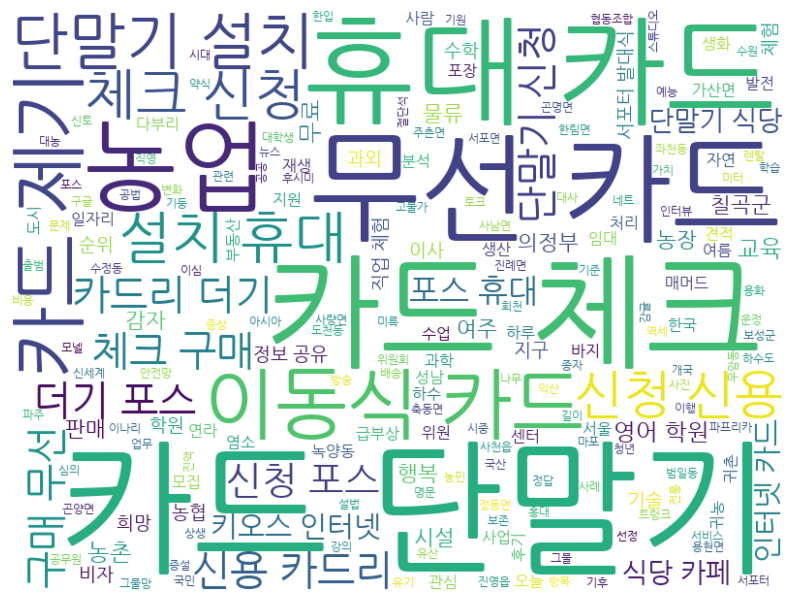

데이터가 농업_cafe_title.csv 파일로 저장되었습니다.


In [4]:
import requests
import re
import csv
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
import emoji

# 네이버 API 키 설정
CLIENT_ID = 'juA2ijfDhrLAObXfhY6_'
CLIENT_SECRET = 'BQDR8znGZI'
STOPWORDS_FILE = 'stopwords-ko.txt'
FONT_PATH = 'NanumGothic.ttf'
OUTPUT_CSV_FILENAME_TEMPLATE = '{}_cafe_title.csv'

# 불용어 로드 함수
def load_stopwords(filepath):
    """Load stopwords from a file."""
    with open(filepath, 'r', encoding='utf-8') as file:
        stopwords = file.read().splitlines()
    return stopwords

# 네이버 카페 데이터 수집 함수
def get_cafe_data(query, display, start=1):
    """Fetch cafe data from Naver API."""
    url = "https://openapi.naver.com/v1/search/cafearticle.json"
    headers = {
        "X-Naver-Client-Id": CLIENT_ID,
        "X-Naver-Client-Secret": CLIENT_SECRET
    }
    params = {
        "query": query,
        "display": display,
        "start": start,
        "sort": "date"
    }
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    return data

# 텍스트 전처리 함수
def clean_text(text):
    """Clean text by removing HTML tags, special characters, and emojis."""
    text = re.sub(r'<[^>]+>', '', text)  # HTML 태그 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
    text = re.sub(r'[^가-힣\s]', '', text)  # 한글 및 공백을 제외한 문자 제거
    text = re.sub(r'\s+', ' ', text)  # 연속된 공백을 하나의 공백으로 변경
    text = emoji.replace_emoji(text, replace='')  # 이모티콘 제거
    return text

# Mecab 초기화
mecab = Mecab(dicpath=r"C:\\mecab\\mecab-ko-dic")

# 제목 내용 추출 및 전처리 함수
def extract_content(data, stopwords):
    """Extract and preprocess content from the fetched cafe data."""
    contents = []
    for item in data['items']:
        content = clean_text(item['title'])  # title 필드를 본문 내용으로 간주
        tokens = mecab.nouns(content)
        filtered_tokens = [word for word in tokens if word not in stopwords and len(word) > 1]
        contents.append({'nouns': ' '.join(filtered_tokens), 'link': item['link']})
    return contents

# 워드클라우드 생성 및 출력 함수
def create_wordcloud(text):
    """Create and display a word cloud from the text."""
    wordcloud = WordCloud(font_path=FONT_PATH, background_color='white', width=800, height=600).generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 데이터 저장 함수
def save_to_csv(contents, filename):
    """Save cafe titles and links to a CSV file."""
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['nouns', 'link'])
        for content in contents:
            writer.writerow([content['nouns'], content['link']])

# 메인 함수
def main():
    """Main function to execute the script workflow."""
    query = input("검색할 단어를 입력하세요: ")
    total_results = int(input("검색할 카페 글 수를 입력하세요: "))
    display = 100  # 한 번에 최대 100개 결과 가져오기
    
    # 불용어 로드
    stopwords = load_stopwords(STOPWORDS_FILE)
    
    # 네이버 카페 데이터 수집
    all_contents = []
    for start in range(1, total_results + 1, display):
        data = get_cafe_data(query, display, start=start)
        contents = extract_content(data, stopwords)
        all_contents.extend(contents)
    
    # 모든 텍스트 합치기
    text = ' '.join([content['nouns'] for content in all_contents])
    
    # 워드클라우드 생성 및 출력
    create_wordcloud(text)
    
    # 데이터 저장
    filename = OUTPUT_CSV_FILENAME_TEMPLATE.format(query)
    save_to_csv(all_contents, filename)
    print(f"데이터가 {filename} 파일로 저장되었습니다.")

# 프로그램 실행
if __name__ == "__main__":
    main()
